In [10]:
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
import gym
import torch
from stable_baselines3.common.callbacks import BaseCallback
import warnings
warnings.filterwarnings('ignore')

In [2]:
server = 'mssql-2017.labs.wmi.amu.edu.pl'
database = 'db_football_players'
username = 'db_football_players'
password = 'Lh4M466Ww7'

connection_string = f"mssql+pyodbc://{username}:{password}@{server}/{database}?driver=ODBC+Driver+17+for+SQL+Server"
engine = create_engine(connection_string)

In [3]:
class GradientClippingCallback(BaseCallback):
    def __init__(self, clip_value=0.5, verbose=0):
        super(GradientClippingCallback, self).__init__(verbose)
        self.clip_value = clip_value

    def _on_step(self):
        torch.nn.utils.clip_grad_norm_(self.model.policy.parameters(), self.clip_value)
        return True

In [4]:
def evaluate_sensitivity(model, environment, feature_indices):
    original_state = environment.reset()
    print("Original state shape:", original_state.shape)
    sensitivities = []
    for idx in feature_indices:
        if idx >= original_state.shape[0]:
            print(f"Index {idx} is out of bounds for the state with shape {original_state.shape}")
            continue
        perturbed_state = np.copy(original_state)
        perturbation = 0.01 * (np.max(original_state) - np.min(original_state))
        perturbed_state[idx] += perturbation
        action, _states = model.predict(original_state, deterministic=True)
        perturbed_action, _ = model.predict(perturbed_state, deterministic=True)
        sensitivity = np.abs(action - perturbed_action)
        sensitivities.append(sensitivity)
    return sensitivities


In [5]:
class TransferEnv(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, scaled_data, original_data):
        super(TransferEnv, self).__init__()
        self.scaled_data = scaled_data
        self.original_data = original_data
        self.teams = original_data['team'].unique()
        self.team_to_idx = {team: idx for idx, team in enumerate(self.teams)}
        self.idx_to_team = {idx: team for team, idx in self.team_to_idx.items()}
        self.action_space = gym.spaces.Discrete(len(self.teams))
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=(len(scaled_data.columns),), dtype=np.float32)

        self.state = self.reset()

    def validate_observations(self, obs):
        if np.isnan(obs).any():
            print("NaN detected in observations")
            obs = np.nan_to_num(obs)
        return obs

    def reset(self):
        self.current_step = 0
        obs = self.scaled_data.iloc[self.current_step].values
        return self.validate_observations(obs)

    def step(self, action):
        action = action.item()
        current_row = self.scaled_data.iloc[self.current_step]
        original_row = self.original_data.iloc[self.current_step]
        proposed_team = self.idx_to_team[action]
        self.current_step += 1
        done = self.current_step >= len(self.scaled_data) - 1 
        reward = self.calculate_reward(original_row['team'], proposed_team, current_row)
        if not done:
            next_state = self.scaled_data.iloc[self.current_step].values
        else:
            next_state = np.zeros_like(self.scaled_data.iloc[0].values)
        
        proposed_elo = self.original_data[self.original_data['team'] == proposed_team]['elo'].values[0] if not self.original_data[self.original_data['team'] == proposed_team].empty else None

        info = {
            'season': original_row['season'],
            'id': original_row['id'],
            'current_elo': original_row['elo'],
            'current_team': original_row['team'],
            'reward': reward,
            'proposed_elo': proposed_elo
        }
        
        return self.validate_observations(next_state), reward, done, info

    def calculate_reward(self, current_team, proposed_team, current_row):
        if self.current_step == 0:
            return 0
        else:
            current_elo = self.scaled_data[self.original_data['team'] == current_team]['elo'].values[0]
            proposed_elo = self.scaled_data[self.original_data['team'] == proposed_team]['elo'].values[0] if not self.original_data[self.original_data['team'] == proposed_team].empty else 0
            elo_reward = proposed_elo - current_elo 
            if self.current_step < len(self.scaled_data) - 1:
                previous_value = self.scaled_data.iloc[self.current_step]['previous_market_value']
                current_value = self.scaled_data.iloc[self.current_step]['marketValue']  
            else:
                previous_value = current_row['previous_market_value']
                current_value = current_row['marketValue']
            market_value_reward = current_value - previous_value 
            reward = elo_reward + market_value_reward 
            return reward            

    def render(self, mode='human', close=False):
        pass

In [6]:
def convert_season(season):
    start, end = season.split('/')

    if int(start) >= 25:
        start = '19' + start
    else:
        start = '20' + start

    if int(end) >= 25:
        end = '19' + end
    else:
        end = '20' + end


    return f"{start}/{end}"
def assign_season(date):
    if date.month < 8:
        return f"{date.year-1}/{date.year}"
    else:
        return f"{date.year}/{date.year+1}"

def generate_value_season(df_player_values):
    df_player_values['date'] = pd.to_datetime(df_player_values['date'], format='%d.%m.%Y', errors='coerce')
    df_player_values['season'] = df_player_values['date'].apply(assign_season)
    return df_player_values

def load_data():

 query_player_seasons = """
 SELECT * FROM [db_football_players].[dbo].[player_seasons]
 """
 df_player_seasons = pd.read_sql(query_player_seasons, engine)

 query_player_values = """
 SELECT * FROM [db_football_players].[dbo].[player_value]
 """
 df_player_values = pd.read_sql(query_player_values, engine)

 query_player_flags = """
 SELECT * FROM [db_football_players].[dbo].[player_flags]
 """
 df_player_flags = pd.read_sql(query_player_flags, engine)

 query_player_transfers = """
 SELECT * FROM [db_football_players].[dbo].[transfers]
 """
 df_player_transfers = pd.read_sql(query_player_transfers, engine)

 query_player_players = """
 SELECT * FROM [db_football_players].[dbo].[players]
 """
 df_player_players = pd.read_sql(query_player_players, engine)

 return df_player_seasons, df_player_values, df_player_flags, df_player_transfers, df_player_players

In [17]:
df_player_seasons, df_player_values, df_player_flags, df_player_transfers, df_player_players = load_data()
df_player_values = generate_value_season(df_player_values)
df_player_transfers['season'] = df_player_transfers['season'].apply(convert_season)
result = pd.merge(df_player_flags, df_player_players, on='id')
result = pd.merge(result, df_player_values, on=['id','season'])
result = pd.merge(result, df_player_transfers, on=['id', 'season'])
label_encoders = {}
file=pd.read_csv('../../data/transfermarkt/elo_combined.csv').drop(columns=['elo_ranking_club']).rename(columns={"club": "team",})
manual_elo_values = {
    'Legia Warszawa': 2057.30,
    'Rakow Czestochowa': 2056.73,
    'Lech Poznan': 2028.27,
    'Jagiellonia Bialystok': 2010.47,
    'Pogon Szczecin': 1979.33,
    'Slask Wroclaw': 1936.03,
    'Piast Gliwice': 1934.58,
    'Cracovia Krakow': 1908.82,
    'Zaglebie Lubin': 1898.70,
    'Gornik Zabrze': 1891.41,
    'Korona Kielce': 1886.56,
    'Radomiak Radom': 1852.95,
    'Widzew Lodz': 1851.43,
    'Ruch Chorzow': 1829.66,
    'Warta Poznan': 1813.30,
    'Puszcza Niepolomice': 1804.84,
    'Stal Mielec': 1764.82,
    'LKS Lodz': 1729.92,
    'Arka Gdynia': 1874.70,
    'Lechia Gdansk': 1836.87,
    'Wisla Krakow': 1834.11,
    'GKS Katowice': 1785.84,
    'Wisla Plock': 1769.47,
    'Motor Lublin': 1766.02,
    'GKS Tychy': 1737.78,
    'Miedz Legnica': 1734.90,
    'LKS Nieciecza': 1722.74,
    'Gornik Leczna': 1696.46,
    'Odra Opole': 1691.37,
    'Polonia Warszawa': 1652.76,
    'Znicz Pruszkow': 1649.86,
    'Resovia Rzeszow': 1646.33,
    'Podbeskidzie Bielsko Biala': 1637.50,
    'Chrobry Glogow': 1636.25,
    'Stal Rzeszow': 1606.55,
    'Zaglebie Sosnowiec': 1572.21,
    'Pogon Siedlce': 1628.91,
    'Kotwica Kolobrzeg': 1618.69,
    'Stal Stalowa Wola': 1613.80,
    'KKS 1925 Kalisz': 1587.47,
    'Olimpia Grudziadz': 1578.32,
    'Chojniczanka Chojnice': 1573.93,
    'Hutnik Krakow': 1566.19,
    'SKRA Czestochowa': 1565.43,
    'Polonia Bytom': 1561.88,
    'Wisla Pulawy': 1548.34,
    'Olimpia Elblag': 1541.09,
    'Stomil Olsztyn': 1511.45,
    'GKS Jastrzebie': 1509.57,
    'Lech Poznan II': 1505.25,
    'Sandecja Nowy Sacz': 1501.80,
    'Lks Lodz II': 1493.72,
    'Zaglebie Lubin II': 1493.26,
    'Radunia Stezyca': 1489.67
}

for club, elo in manual_elo_values.items():
    file.loc[file['team'] == club, 'elo'] = elo
result= pd.merge(result, file, on=['team'])
result.to_csv('football_players_data.csv')
for column in [ 'season', 'team', 'RED_CARD_PLAYER', 'VALUE_FLAG', 'ZERO_EXP',
    'ALWAYS_ON_BENCH', 'PROGRESS_SINCE_NEW_TEAM',
    'SAME_RESULTS_FOR_LONG_TIME', 'YELLOW_CARD_PLAYER', 'place_of_birth', 'birth_date', 'nationality','position',
    'manager', 'club', 'fee','clubName1', 'clubName2']:
    le = LabelEncoder()
    result[column] = le.fit_transform(result[column])
    label_encoders[column] = le
result = result.sort_values(by=['id', 'season'])

result['previous_market_value'] = result.groupby('id')['marketValue'].shift(1)
result['previous_market_value'] = result['previous_market_value'].fillna(result['marketValue'])

target = result['marketValue']
result['height'] = result['height'].fillna(1.80)
features = result.drop(columns=['marketValue','slug', 'name', 'date_x', 'date_y','place_of_birth', 'manager','clubName1', 'clubName2','value', 'club'])
features2 = result.drop(columns=['slug', 'name', 'date_x', 'date_y'])

unique_ids = result['id'].unique()
train_ids, test_ids = train_test_split(unique_ids, test_size=0.25, random_state=42)

train_data = result[result['id'].isin(train_ids)]
test_data = result[result['id'].isin(test_ids)]

X_train = train_data.drop(columns=['marketValue','slug', 'name', 'date_x', 'date_y','place_of_birth', 'manager','clubName1', 'clubName2', 'value', 'club'])
y_train = train_data['marketValue']
X_test = test_data.drop(columns=['marketValue','slug', 'name', 'date_x', 'date_y','place_of_birth', 'manager','clubName1', 'clubName2', 'value', 'club'])
y_test = test_data['marketValue']

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
predictions  = model.predict(X_test)

mse = mean_squared_error(y_test, predictions)
rmse = root_mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R2 Score: {r2}')

MSE: 3135954826473996.0
RMSE: 55999596.66349389
R2 Score: 0.6567528837026527


previous_market_value    0.711783
fee                      0.059060
elo                      0.032234
season                   0.028527
nationality              0.027303
id                       0.024851
height                   0.023651
birth_date               0.022592
team                     0.017754
age                      0.017615
dtype: float64


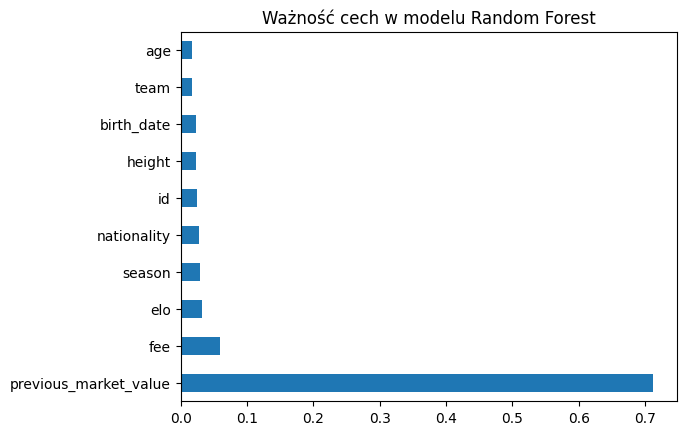

In [8]:
if isinstance(features, pd.DataFrame):
    feature_names = features.columns.tolist()
else:
    feature_names = features
feat_importances = pd.Series(model.feature_importances_, index=feature_names)
print(feat_importances.nlargest(10))
feat_importances.nlargest(10).plot(kind='barh')
plt.title('Ważność cech w modelu Random Forest')
plt.show()


In [11]:
ss = StandardScaler()
df_scaled = pd.DataFrame(ss.fit_transform(features2), columns=features2.columns)

data = df_scaled
env = TransferEnv(data,features2)


model_rl = PPO("MlpPolicy", env, verbose=1, learning_rate=0.0001)
model_rl.learn(total_timesteps=20000, callback=GradientClippingCallback(clip_value=0.5))
feature_indices = range(len(features))
sensitivities = evaluate_sensitivity(model_rl, env, feature_indices)
print("Feature sensitivities:", sensitivities)

obs = env.reset()
for _ in range(1000):
    action, _states = model_rl.predict(obs)
    obs, rewards, dones, info = env.step(action)
    print(f"Action taken: {action}, Reward received: {rewards}")
    if dones:
        break

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 121  |
|    iterations      | 1    |
|    time_elapsed    | 16   |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 115         |
|    iterations           | 2           |
|    time_elapsed         | 35          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.009151204 |
|    clip_fraction        | 0.00684     |
|    clip_range           | 0.2         |
|    entropy_loss         | -7.95       |
|    explained_variance   | -0.0137     |
|    learning_rate        | 0.0001      |
|    loss                 | 38.4        |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0541     |
|    value_loss         

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Action taken: 1895, Reward received: 0.415175688916849
Action taken: 1637, Reward received: 1.734636586770661
Action taken: 2554, Reward received: 0.5260063598618974
Action taken: 2072, Reward received: -0.6575539955917268
Action taken: 490, Reward received: 1.6529874869628414
Action taken: 280, Reward received: -3.254935405343969
Action taken: 2802, Reward received: -2.936084100969545
Action taken: 1721, Reward received: -1.1935539167387326
Action taken: 908, Reward received: -0.9155752151404081
Action taken: 2659, Reward received: 0.08421544948413631
Action taken: 2762, Reward received: 1.9121509379309658
Action taken: 1052, Reward received: 2.4653519224625517
Action taken: 632, Reward received: -0.4215879586581206
Action taken: 189, Reward received: 2.11982334444291
Action taken: 2185, Reward received: -0.13817497580477936
Action taken: 2322, Reward received: 0.05629560117632432
Action taken: 1192, Reward received: -0.6740925518954046
Action taken: 1444, Reward received: -0.50349333

In [12]:
club_encoder = label_encoders['team']
season_encoder = label_encoders['season']
inverse_season_mapping = {index: label for index, label in enumerate(season_encoder.classes_)}
inverse_club_mapping = {index: label for index, label in enumerate(club_encoder.classes_)}

model_rl = PPO("MlpPolicy", env, verbose=1, learning_rate=0.0001)
model_rl.learn(total_timesteps=20000, callback=GradientClippingCallback(clip_value=0.5))
obs = env.reset()
for _ in range(1000):
    action, _states = model_rl.predict(obs)
    action2 = action.item()
    club_name = inverse_club_mapping[action2]
    club_name2 = inverse_club_mapping[info['current_team']]
    season = inverse_season_mapping[info['season']]
    obs, rewards, dones, info = env.step(action)
    if info['reward'] >=0:
        print(f"Action taken: {action}, 'Current club: {club_name2}, Proposed club: {club_name}, Season: {season}, Player ID: {info['id']}, Current ELO: {info['current_elo']}, Proposed ELO: {info['proposed_elo']}, Reward: {info['reward']}")
    if dones:
        break

{'season': LabelEncoder(), 'team': LabelEncoder(), 'RED_CARD_PLAYER': LabelEncoder(), 'VALUE_FLAG': LabelEncoder(), 'ZERO_EXP': LabelEncoder(), 'ALWAYS_ON_BENCH': LabelEncoder(), 'PROGRESS_SINCE_NEW_TEAM': LabelEncoder(), 'SAME_RESULTS_FOR_LONG_TIME': LabelEncoder(), 'YELLOW_CARD_PLAYER': LabelEncoder(), 'place_of_birth': LabelEncoder(), 'birth_date': LabelEncoder(), 'nationality': LabelEncoder(), 'position': LabelEncoder(), 'manager': LabelEncoder(), 'club': LabelEncoder(), 'fee': LabelEncoder(), 'clubName1': LabelEncoder(), 'clubName2': LabelEncoder()}
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 131  |
|    iterations      | 1    |
|    time_elapsed    | 15   |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 122         |
|    iter